# Real-NVPs

**Goal:** Implement a Real-NVP model on your own and evaluate the results on some **toy problem**.

![](flow-graphic.png)


**Table of Contents:**
1. [Dataset](#data) 
2. [Model architecture](#model)
- Q1: Implement the t (translation) NN in the `CouplingLayer` 
- Q2: Implement the forward function n the `CouplingLayer` 
- Q3: Implement the log(det(Jacobian)) for the reverse function
3. [Training](#train)
- Q4: Add the loss function definition to the `train` function
- Q5: Visualize the density of $f^{-1}(X)$ for a trained model
4. [(Bonus) visualizations](#viz)
- Code already provided, just for fun to look at what the step-by-step flow denisty propogation is doing.

## 1. Dataset
<a name="data"></a>

Let's _start_ with the crescent moons dataset as a nice 2d test bed example

In [1]:
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt


import math
import numpy as np
import torch
import torch.nn as nn

In [2]:
nsamples = 30_000
noise = 0.05
X = make_moons(nsamples, noise=noise)[0]

Text(0, 0.5, '$X_1$')

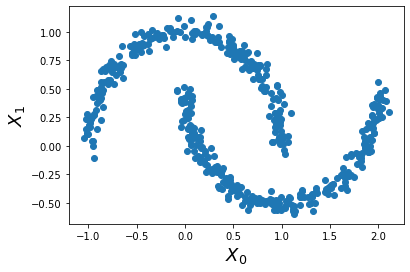

In [3]:
nViz=500

plt.scatter(X[:nViz,0], X[:nViz,1])

plt.xlabel('$X_0$',fontsize=18)
plt.ylabel('$X_1$',fontsize=18)

## 2. Model architecture
<a name="model"></a>

### Implementation detail: Masking

In the lecture, we talked about the affine transformations transforming a bipartite grouping of the variables (via "coupling layers").

I.e, for $f: x \rightarrow y, x,y \in \mathbb{R}^n$, we group the variables into the <span style="color:deeppink">transforming dimensions</span> and <span style="color:blue">conditioning dimensions</span>, and just transfom one set of variables at a time, while leaving the others stationary, e.g,

$$ y_{1:d} = x_{1:d} $$
$$y_{d+1:D} = x_{d+1:D} \cdot s(x_{1:d})  + t(x_{1:d})$$

(and in the next step of the flow $x_{1:d}$ would get transformed while $x_{d+1:D}$ would be useds for the conditioning).

As described in [1605.08803](https://arxiv.org/abs/1605.08803), it's common to implement the variable partitioning with a binary mask, here denoted $m$, where
$$
m_i = 
\begin{cases}
0, \quad \text{transforming dimension} \\
1, \quad \text{conditioning dimension}
\end{cases}
$$
This allows us to implement the the update eqs for a single flow step more succinctly as:

$$y =  m \odot x + (1-m) \odot \left[x \cdot s(m \odot x )  + t(m \odot x ) \right].$$



We simplify a little bit to try to get into a more succinct form.

- Write in terms of `log_s` (as this is the NN we have).

$$y =  m \odot x + (1-m) \odot \left[x \cdot \exp \log s(m \odot x )  + t(m \odot x ) \right]$$

- Group the terms with $x$ together.

$$y =  x \odot \left[ m  + (1-m) \cdot \exp \log s(m \odot x ) \right]  + t(m \odot x ) \cdot (1-m)$$

We want to take the `exp` outside of the expression in $[ \ldots ]$.

Note that

$$\exp(m_i) = 
1, \  \ \text{if} \ m_i = 0 .$$


$$y =  x \odot  \exp \left[( \log s(m \odot x ) \cdot (1-m)  \right]  + t(m \odot x ) \cdot (1-m)$$

In [17]:
class CouplingLayer(nn.Module):
    """ An implementation of a coupling layer
    from RealNVP (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self, num_inputs, num_hidden, mask):
        super(CouplingLayer, self).__init__()

        self.num_inputs = num_inputs
        self.mask = mask
            
        self.log_s_net = nn.Sequential(
            nn.Linear(num_inputs, num_hidden), nn.Tanh(),
            nn.Linear(num_hidden, num_hidden), nn.Tanh(),
            nn.Linear(num_hidden, num_inputs))
        
        '''
        TO DO (Q1): Setup the network for the shift of the affine transformation
        - Use 2 hidden layers
        - `num_hidden` units / hidden layer
        - ReLU activation
        '''
        self.t_net = 

    def forward(self, inputs,  mode='forward'):
        '''
        Returns a tuple with 
        - the transofrmation, f(inpts)
        - and the log Jacobian of f

        Whether we apply f or f^{-1} depends on whether we're running 
        with `mode` as forward or reverse
        '''
        mask = self.mask
        masked_inputs = inputs * mask
        
        if mode == 'forward':
            
            '''
            TO DO (Q2): Implement the transformation
            '''
            
            log_s = 
            s = 
            t = 
            out = 
            
            return out, log_s.sum(-1, keepdim=True)
                        
        else:
            
            log_s = self.log_s_net(masked_inputs) * (1 - mask)
            t = self.t_net(masked_inputs) * (1 - mask)
            s = torch.exp(log_s)
            
            '''
            TO DO (Q3): Implement the Jacobian
            '''
            log_jacob = 
            
            return (inputs - t) / s, log_jacob

### Sanity check

After working through steps (1) -- (3), the CouplingLayer class should work :) 

And the code block below let's you check the implementation.

![](frogs.png)

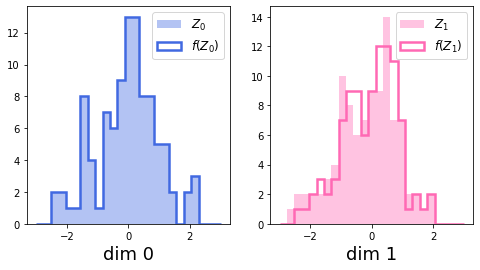

In [18]:
# Generate a random normally distributed vector 
# with 100 samples in 2 dimensions
Z = torch.randn(100,2)

# dim 0 will be the conditioning variable
# dim 1 will be the transforming variable
mask = torch.Tensor([1,0])
f = CouplingLayer(2,64,mask)

with torch.no_grad():
    out, log_p = f(Z)

# The histogram shows the inputs and the outputs
fig, axes = plt.subplots(1,2,figsize=(8,4))

for i, ax, c in zip([0,1],axes,['royalblue','hotpink']):

    ax.hist(Z[:,i].numpy(),25,(-3,3),label=f'$Z_{i}$',color=c,alpha=.4)
    ax.hist(out[:,i].numpy(),25,(-3,3),label=f'$f(Z_{i})$',color=c,lw=2.5,histtype='step')
    
    ax.set_xlabel(f'dim {i}',fontsize=18)
    ax.legend(fontsize=12)
    
plt.show()

^ Is the result what you expected?

The `FlowSequential` then stitches together a sequence of CouplingLayers together to form a single model that can evaluate eitheer

For this tutorial we're giving a ready-to-go implementation `FlowSequential` class :)


In [19]:
class FlowSequential(nn.Sequential):
    """ A sequential container for flows.
    In addition to a forward pass it implements a backward pass and
    computes log jacobians.
    """

    def forward(self, inputs, mode='forward', logdets=None):
        """ Performs a forward or reverse pass for flow modules.
        Args:
            inputs: a tuple of inputs and logdets
            mode: to run direct computation or inverse
        """
        
        self.num_inputs = inputs.size(-1)

        if logdets is None:
            logdets = torch.zeros(inputs.size(0), 1, device=inputs.device)

        assert mode in ['forward', 'reverse']
        if mode == 'forward':
            for module in self._modules.values():
                inputs, logdet = module(inputs, mode)
                logdets += logdet
        else:
            for module in reversed(self._modules.values()):
                inputs, logdet = module(inputs, mode)
                logdets += logdet

        return inputs, logdets

    def log_probs(self, inputs):
        u, log_jacob = self(inputs,mode='reverse')
          
        log_probs = (-0.5 * u.pow(2) - 0.5 * math.log(2 * math.pi)).sum(-1, keepdim=True)
        return (log_probs + log_jacob).sum(-1, keepdim=True)

    def sample(self, num_samples=None, noise=None):
        
        if noise is None:
            noise = torch.Tensor(num_samples, self.num_inputs).normal_()
            
        device = next(self.parameters()).device
        noise = noise.to(device)

        samples = self.forward(noise, mode='forward')[0]
        
        return samples

### Flow architecture

Let's consider a flow with 9 blocks and the $\log(s)$ and $t$ NNs with 64 hidden units per hidden layer.

In [39]:
num_blocks=9
num_hidden=64

In [40]:
# Check for a GPU
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device='cpu'
    
print(device)

cuda:0


In [41]:
num_inputs = X.shape[1]

mask = torch.arange(0, num_inputs) % 2
mask = mask.to(device).float()

modules=[]

for _ in range(num_blocks):
    modules.append( CouplingLayer( num_inputs, num_hidden, mask) )
    mask = 1 - mask

In [42]:
model = FlowSequential(*modules)

Sometimes flow architectures use non-default initialization schemes. 
Here initialize the Linear layers with an orthogonal weight values and 0 biases.

In [43]:
for module in model.modules():
    if isinstance(module, nn.Linear):
        nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            module.bias.data.fill_(0)

## 4. Training
<a name="train"></a>

In [44]:
X_torch = torch.Tensor(X.astype(np.float32))

In [45]:
batch_size=256

nTrain=24_000
nVal=3_000

In [47]:
kwargs = {'num_workers': 4, 'pin_memory': True}  if torch.cuda.is_available() else {}

In [48]:
train_loader = torch.utils.data.DataLoader(
    X_torch[:nTrain], batch_size=batch_size, shuffle=True,**kwargs)

valid_loader = torch.utils.data.DataLoader(
    X_torch[nTrain : nTrain+nVal],
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    **kwargs)

test_loader = torch.utils.data.DataLoader(
    X_torch[nTrain+nVal :],
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    **kwargs)

In [49]:
def train(model, train_loader):
    
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(train_loader):
   
        data = data.to(device)
        optimizer.zero_grad()
        
        '''
        TO DO (Q4): Fill in the expression for the loss
        '''
        loss = 
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    return train_loss

In [50]:
def validate(model, loader, prefix='Validation'):
    
    model.eval()
    val_loss = 0

    for batch_idx, data in enumerate(loader):

        data = data.to(device)
        with torch.no_grad():
            val_loss += -model.log_probs(data).sum().item()  # sum up batch loss
     
    val_loss /= len(loader.dataset)
    return val_loss 

In [51]:
lr=1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

In [52]:
def draw_model(model, title=''):
    '''
    Goal: Given the given model weights, show
    (1) The density
    (2) Samples from p_X(x)
    '''
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4),
                                  gridspec_kw={'hspace':10})

    # Title the plot with the log(p) on the validation set
    if title:
        fig.suptitle(title)

    '''
    (1) Plot the density
    '''
    x = np.linspace(-1,2)
    y = np.linspace(-.75,1.25)

    xx,yy = np.meshgrid(x,y)

    X_grid = np.vstack([xx.flatten(),yy.flatten()]).T.astype(np.float32)
    X_grid.T

    X_gpu = torch.tensor(X_grid).to(device)

    with torch.no_grad():
        log_probs = model.log_probs(torch.tensor(X_grid).to(device)).cpu().numpy()

    ax1.pcolormesh(xx,yy,np.exp(log_probs.reshape(50,50)),shading='auto',cmap='coolwarm')

    ax1.set_xlabel('$X_0$',fontsize=12)
    ax1.set_ylabel('$X_1$',fontsize=12)

    '''
    (2) Plot samples from the model
    '''
    with torch.no_grad():
        X_gen = model.sample(500).cpu().numpy()
        
    ax2.scatter(*X_gen.T)

    ax2.set_xlabel('$X_0$',fontsize=12)
    ax2.set_ylabel('$X_1$',fontsize=12)

    ax2.set_xlim(x[[0,-1]])
    ax2.set_ylim(y[[0,-1]])

    plt.show()


In [53]:
model.to(device)

FlowSequential(
  (0): CouplingLayer(
    (log_s_net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
    (t_net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (1): CouplingLayer(
    (log_s_net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
    (t_net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3)

Epoch 0: train loss = 1.8602, val loss = 1.8362


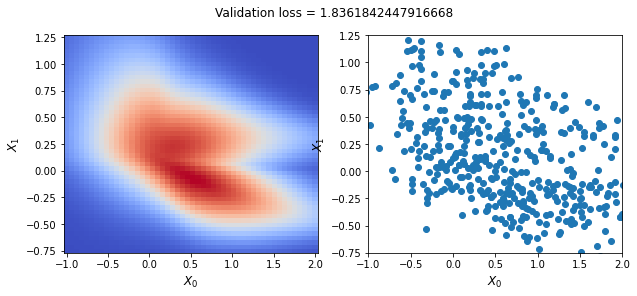

Epoch 1: train loss = 1.7997, val loss = 1.7609
Epoch 2: train loss = 1.6897, val loss = 1.6082
Epoch 3: train loss = 1.4464, val loss = 1.3334
Epoch 4: train loss = 1.1962, val loss = 1.1907
Epoch 5: train loss = 1.1158, val loss = 1.1149
Epoch 6: train loss = 1.0595, val loss = 1.0831
Epoch 7: train loss = 1.0195, val loss = 1.0208
Epoch 8: train loss = 0.9774, val loss = 0.9972
Epoch 9: train loss = 0.9431, val loss = 0.9595
Epoch 10: train loss = 0.9164, val loss = 0.9504


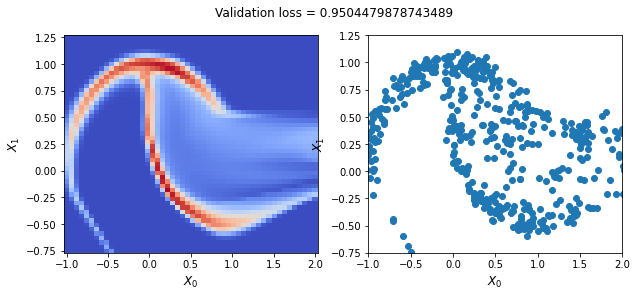

Epoch 11: train loss = 0.8945, val loss = 0.8955
Epoch 12: train loss = 0.8727, val loss = 0.8820
Epoch 13: train loss = 0.8752, val loss = 0.8875
Epoch 14: train loss = 0.8501, val loss = 0.8512
Epoch 15: train loss = 0.8266, val loss = 0.8421
Epoch 16: train loss = 0.8206, val loss = 0.8436
Epoch 17: train loss = 0.8115, val loss = 0.8114
Epoch 18: train loss = 0.7979, val loss = 0.7951
Epoch 19: train loss = 0.8184, val loss = 0.8126
Epoch 20: train loss = 0.7933, val loss = 0.8116


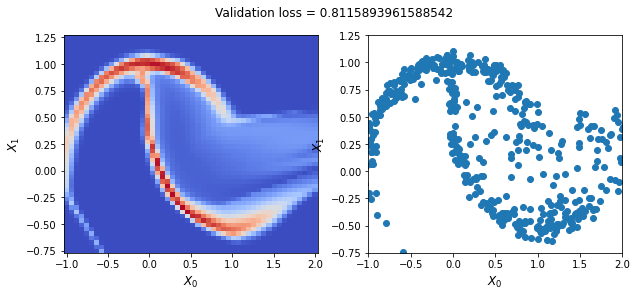

Epoch 21: train loss = 0.7718, val loss = 0.7689
Epoch 22: train loss = 0.7506, val loss = 0.7952
Epoch 23: train loss = 0.7603, val loss = 0.7486
Epoch 24: train loss = 0.7353, val loss = 0.7273
Epoch 25: train loss = 0.7210, val loss = 0.7160
Epoch 26: train loss = 0.7064, val loss = 0.6954
Epoch 27: train loss = 0.6962, val loss = 0.6880
Epoch 28: train loss = 0.6786, val loss = 0.6736
Epoch 29: train loss = 0.6760, val loss = 0.6658
Epoch 30: train loss = 0.7270, val loss = 0.7322


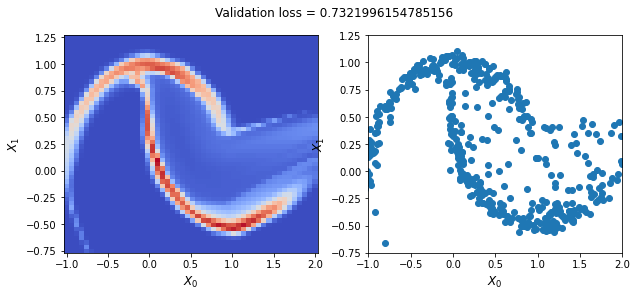

Epoch 31: train loss = 0.6885, val loss = 0.6910
Epoch 32: train loss = 0.6658, val loss = 0.7012
Epoch 33: train loss = 0.6681, val loss = 0.6628
Epoch 34: train loss = 0.6406, val loss = 0.6484
Epoch 35: train loss = 0.6373, val loss = 0.6321
Epoch 36: train loss = 0.6275, val loss = 0.6237
Epoch 37: train loss = 0.6219, val loss = 0.6261
Epoch 38: train loss = 0.6172, val loss = 0.6078
Epoch 39: train loss = 0.6144, val loss = 0.6144
Epoch 40: train loss = 0.5985, val loss = 0.5974


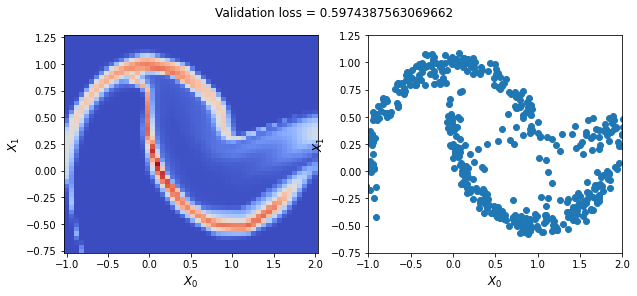

Epoch 41: train loss = 0.5891, val loss = 0.6006
Epoch 42: train loss = 0.5900, val loss = 0.5807
Epoch 43: train loss = 0.5785, val loss = 0.5779
Epoch 44: train loss = 0.5760, val loss = 0.5688
Epoch 45: train loss = 0.5713, val loss = 0.5852
Epoch 46: train loss = 0.5714, val loss = 0.5964
Epoch 47: train loss = 0.5709, val loss = 0.5985
Epoch 48: train loss = 0.5548, val loss = 0.5511
Epoch 49: train loss = 0.8417, val loss = 0.7879
Epoch 50: train loss = 0.7195, val loss = 0.7019


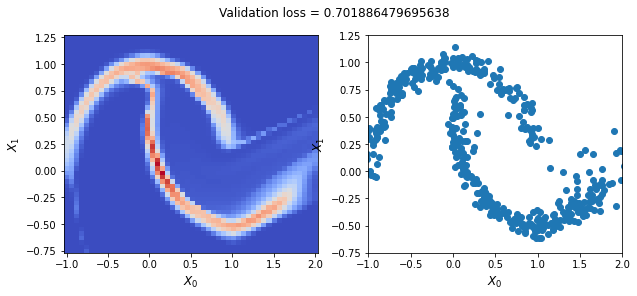

Epoch 51: train loss = 0.6701, val loss = 0.6736
Epoch 52: train loss = 0.6497, val loss = 0.6508
Epoch 53: train loss = 0.6330, val loss = 0.6398
Epoch 54: train loss = 0.6212, val loss = 0.6308
Epoch 55: train loss = 0.6125, val loss = 0.6214
Epoch 56: train loss = 0.6035, val loss = 0.6089
Epoch 57: train loss = 0.5956, val loss = 0.6017
Epoch 58: train loss = 0.5877, val loss = 0.5941
Epoch 59: train loss = 0.5793, val loss = 0.5870
Epoch 60: train loss = 0.5738, val loss = 0.5800


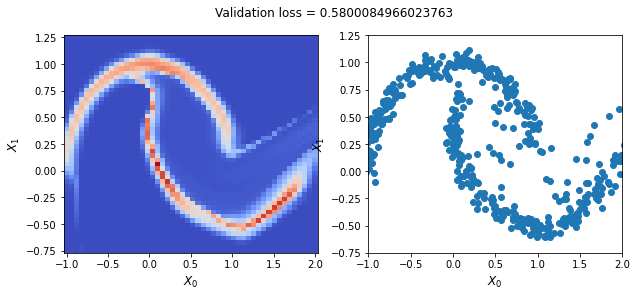

Epoch 61: train loss = 0.5659, val loss = 0.5774
Epoch 62: train loss = 0.5609, val loss = 0.5703
Epoch 63: train loss = 0.5545, val loss = 0.5634
Epoch 64: train loss = 0.5471, val loss = 0.5544
Epoch 65: train loss = 0.5407, val loss = 0.5482
Epoch 66: train loss = 0.5339, val loss = 0.5391
Epoch 67: train loss = 0.5256, val loss = 0.5309
Epoch 68: train loss = 0.5151, val loss = 0.5184
Epoch 69: train loss = 0.5082, val loss = 0.5111
Epoch 70: train loss = 0.4991, val loss = 0.4976


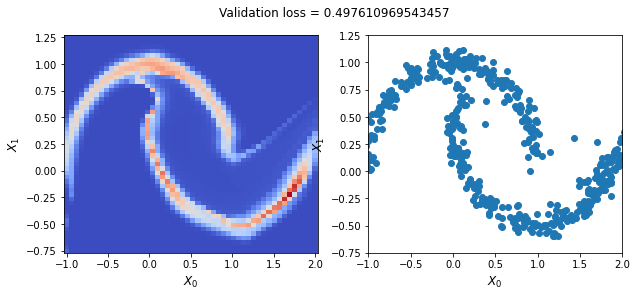

Epoch 71: train loss = 0.4893, val loss = 0.4870
Epoch 72: train loss = 0.4763, val loss = 0.4733
Epoch 73: train loss = 0.4632, val loss = 0.4619
Epoch 74: train loss = 0.4523, val loss = 0.4496
Epoch 75: train loss = 0.4459, val loss = 0.4374
Epoch 76: train loss = 0.4398, val loss = 0.4436
Epoch 77: train loss = 0.4346, val loss = 0.4258
Epoch 78: train loss = 0.4266, val loss = 0.4245
Epoch 79: train loss = 0.4213, val loss = 0.4189
Epoch 80: train loss = 0.4161, val loss = 0.4099


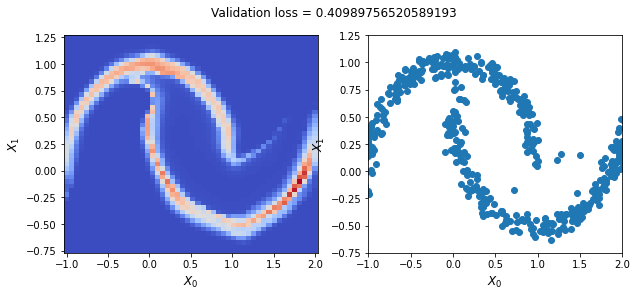

Epoch 81: train loss = 0.4130, val loss = 0.4106
Epoch 82: train loss = 0.4075, val loss = 0.4042
Epoch 83: train loss = 0.4062, val loss = 0.3999
Epoch 84: train loss = 0.4011, val loss = 0.4012
Epoch 85: train loss = 0.4001, val loss = 0.3996
Epoch 86: train loss = 0.3961, val loss = 0.3983
Epoch 87: train loss = 0.3916, val loss = 0.3919
Epoch 88: train loss = 0.3931, val loss = 0.3982
Epoch 89: train loss = 0.3894, val loss = 0.3983
Epoch 90: train loss = 0.3879, val loss = 0.3932


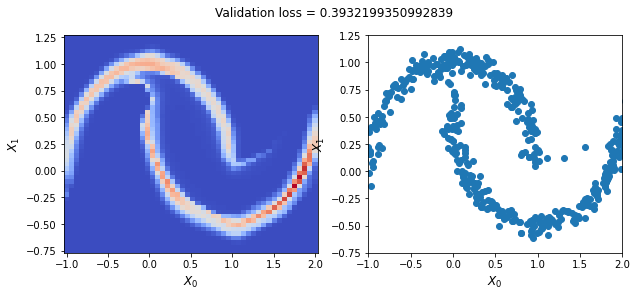

Epoch 91: train loss = 0.3832, val loss = 0.3868
Epoch 92: train loss = 0.3818, val loss = 0.3850
Epoch 93: train loss = 0.3813, val loss = 0.3809
Epoch 94: train loss = 0.3766, val loss = 0.3811
Epoch 95: train loss = 0.3764, val loss = 0.3761
Epoch 96: train loss = 0.3730, val loss = 0.3756
Epoch 97: train loss = 0.3723, val loss = 0.3908
Epoch 98: train loss = 0.3749, val loss = 0.3712
Epoch 99: train loss = 0.3713, val loss = 0.3824
Epoch 100: train loss = 0.3708, val loss = 0.3738


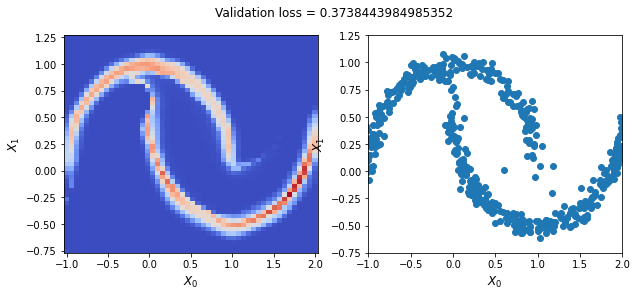

In [55]:
epochs=101

train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)

for i in range(epochs):
    
    train_losses[i] = train(model, train_loader)
    val_losses[i] = validate(model, valid_loader)

    print(f'Epoch {i}: train loss = {train_losses[i]:.4f}, val loss = {val_losses[i]:.4f}')
        
    if i % 10 == 0:
        # Draw the model prediction
        draw_model(model,f'Validation loss = {val_losses[i]}')
        


Plot the training and validation loss.

In [ ]:
plt.plot(train_losses,label='train')
plt.plot(val_losses,label='val')

plt.xlabel('epochs',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.legend(fontsize=15)
plt.show()

**What's the density of the test data _after_ training?**

Text(0, 0.5, '$Z_1$')

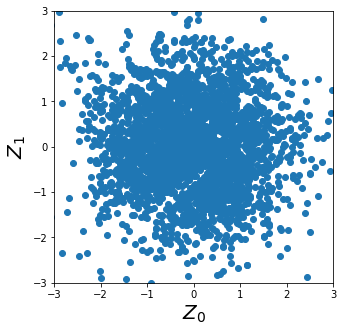

In [56]:
'''
TO DO (Q5): Get the (2d) density of the test data
'''

with torch.no_grad():
    Z_test = 

plt.figure(figsize=(5,5))

plt.scatter(*Z_test.T)

plt.xlim(-3,3)
plt.ylim(-3,3)

plt.xlabel('$Z_0$',fontsize=20)
plt.ylabel('$Z_1$',fontsize=20)


Is this what we expect for the trained flow?

## 4. Vizualize the flow
<a name="viz"></a>

This was a 9 step flow, so let's sample some noise, and look at each of the 10 steps of the flow that goes into the crescent moon density :)

In [57]:
N = 500
Z = torch.randn(N,2)

In [58]:
cmask = np.where((Z[:,0]<0) & (Z[:,1] >0),0,
                np.where((Z[:,0]>0) & (Z[:,1] >0),1,
                        np.where((Z[:,0]>0) & (Z[:,1]<0),2,3)))

In [59]:
colors = [f'C{i}' for i in cmask ]

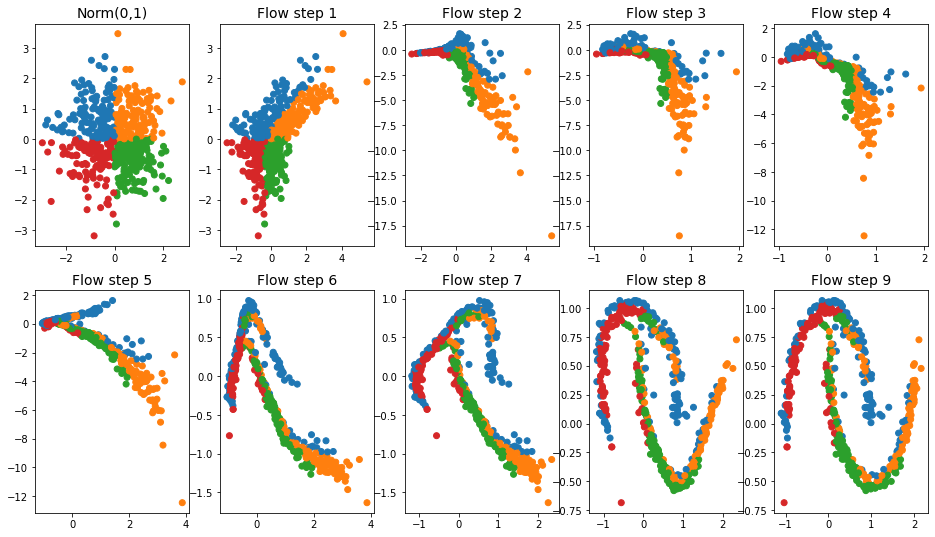

In [65]:
nrows = 2
ncols = 5

fig, ax = plt.subplots(nrows,ncols,figsize=(16,9))

ax[0,0].scatter(*Z.T, color=colors)
ax[0,0].set_title('Norm(0,1)',fontsize=14)

'''
Let each subsequent step of the flow viz the jazz
'''

Z_gpu = Z.float().to(device)

for k,module in enumerate(modules):
    
    with torch.no_grad():    
        Z_gpu, _ = module(Z_gpu)
    
    
    i = (k+1) // ncols
    j = (k+1) % ncols
    
    ax[i,j].set_title(f'Flow step {k+1}',fontsize=14)
    
    ax[i,j].scatter(*Z_gpu.cpu().numpy().T, color=colors)
      
plt.show()

**Resources:**
- This tutorial for the code in this repo came from the [pytorch-flows](https://github.com/ikostrikov/pytorch-flowshttps://github.com/ikostrikov/pytorch-flows) repo.
- The [nflows]() is also a very nice package that includes the Real-NVP model and also the RQ-NSF that we also talked about in the lecture.